In [4]:
# !pip install tensorboardx 
# !pip install pyyaml docopt matplotlib scikit-image
# !pip install "python-doctr[torch]"

In [1]:

import os
import os.path as osp
import pprint
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage.transform
import torch
import yaml
from docopt import docopt

import lcnn
import cv2 
from lcnn.config import C, M
from lcnn.models.line_vectorizer import LineVectorizer
from lcnn.models.multitask_learner import MultitaskHead, MultitaskLearner
from lcnn.postprocess import postprocess
from lcnn.utils import recursive_to

PLTOPTS = {"color": "#33FFFF", "s": 15, "edgecolors": "none", "zorder": 5}
cmap = plt.get_cmap("jet")
norm = mpl.colors.Normalize(vmin=0.9, vmax=1.0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


def c(x):
    return sm.to_rgba(x)


def load_model():
    config_file =  "config/wireframe.yaml"
    C.update(C.from_yaml(filename=config_file))
    M.update(C.model)
    pprint.pprint(C, indent=4)

    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)

    device_name = "cpu"
    if torch.cuda.is_available():
        device_name = "cuda"
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed(0)
        print("Let's use", torch.cuda.device_count(), "GPU(s)!")
    else:
        print("CUDA is not available")
    device = torch.device(device_name)
    checkpoint = torch.load("190418-201834-f8934c6-lr4d10-312k.pth", map_location=device)

    # Load model
    model = lcnn.models.hg(
        depth=M.depth,
        head=lambda c_in, c_out: MultitaskHead(c_in, c_out),
        num_stacks=M.num_stacks,
        num_blocks=M.num_blocks,
        num_classes=sum(sum(M.head_size, [])),
    )
    model = MultitaskLearner(model)
    model = LineVectorizer(model)
    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.to(device)
    model.eval()
    return model,device
def infer(model,im,device):
    if isinstance(im,str):
        im = skimage.io.imread(im)
    
    if im.ndim == 2:
        im = np.repeat(im[:, :, None], 3, 2)
    im = im[:, :, :3]
    im_resized = skimage.transform.resize(im, (512, 512)) * 255
    image = (im_resized - M.image.mean) / M.image.stddev
    image = torch.from_numpy(np.rollaxis(image, 2)[None].copy()).float()
    with torch.no_grad():
        input_dict = {
            "image": image.to(device),
            "meta": [
                {
                    "junc": torch.zeros(1, 2).to(device),
                    "jtyp": torch.zeros(1, dtype=torch.uint8).to(device),
                    "Lpos": torch.zeros(2, 2, dtype=torch.uint8).to(device),
                    "Lneg": torch.zeros(2, 2, dtype=torch.uint8).to(device),
                }
            ],
            "target": {
                "jmap": torch.zeros([1, 1, 128, 128]).to(device),
                "joff": torch.zeros([1, 1, 2, 128, 128]).to(device),
            },
            "mode": "testing",
        }
        H = model(input_dict)["preds"]

    lines = H["lines"][0].cpu().numpy() / 128 * im.shape[:2]
    scores = H["score"][0].cpu().numpy()
    for i in range(1, len(lines)):
        if (lines[i] == lines[0]).all():
            lines = lines[:i]
            scores = scores[:i]
            break

    # postprocess lines to remove overlapped lines
    diag = (im.shape[0] ** 2 + im.shape[1] ** 2) ** 0.5
    nlines, nscores = postprocess(lines, scores, diag * 0.01, 0, False)
    keep_idx=nscores>0.95
    nlines,nscores=nlines[keep_idx,:],nscores[keep_idx]
    return nlines,nscores,im
            

In [2]:
class VisionClient:
    def __init__(self):
        import doctr
        
        self.model=doctr.models.ocr_predictor('fast_base','parseq',pretrained=True)

    

    def infer(self, image):      
        print(isinstance(image,str))  
        if isinstance(image,str):
            image = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
        
        results=self.model([image])
        H,W,C=image.shape    
        id_counter = 0
        res=[]
        for page in results.pages:
            for block in page.blocks:
                for line in block.lines:
                    for word in line.words:  # The bounding box geometry of the word
                        text_value = word.value  # The recognized text value
                        (x_min, y_min), (x_max, y_max) = word.geometry  # Convert geometry to bounding box coordinates

                        # Create the result dictionary in the desired format
                        result_dict = {
                            "text": text_value,
                            "box": [x_min*W, y_min*H, x_max*W, y_max*H],
                        }
                        res.append(result_dict)
                        id_counter += 1  # Increment ID counter for each word
        return res


In [3]:
class Line:
    def __init__(self, point1, point2):
        """
        Initialize the li4467ne using two points (x1, y1) and (x2, y2).

        Args:
            point1 (tuple): The first point (x1, y1).
            point2 (tuple): The second point (x2, y2).
        """
        y1, x1 = point1
        y2, x2 = point2


        # Calculate the slope (m) and intercept (b)
        self.m = (y2 - y1) / ((x2 - x1)+1e-5)
        self.b = y1 - self.m * x1
        self.is_vertical=abs(self.m)>1
        self.is_horizontal=abs(self.m)<1
        if self.is_horizontal:
            self.point1,self.point2=sorted([point1,point2],key=lambda x:x[1])
        else:
            self.point1,self.point2=sorted([point1,point2],key=lambda x:x[0])

    def y(self, x):
        """
        Calculate y for a given x using the line equation y = mx + b.

        Args:
            x (float): The x-coordinate.

        Returns:
            float: The corresponding y-coordiis_verticalnate.
        """
        return self.m * x + self.b

    def x(self, y):
        """
        Calculate x for a given y using the inverse of the line equation x = (y - b) / m.

        Args:,nscores
            y (float): The y-coordinate.

        Returns:
            float: The corresponding x-coordinate.
        """
        if self.m == 0:
            raise ValueError("The slope (m) is zero; the line is horizontal.")
        
        return (y - self.b) / self.m
    def stretch_limits(self,low_limit,high_limit):
        if self.is_horizontal:
            self.point1=low_limit
            self.point2=high_limit
        else:
            if isinstance(low_limit,(tuple,list)):
                self.point1=low_limit
            else:
                self.point1=(low_limit,self.x(low_limit))
            if isinstance(high_limit,(tuple,list)):
                self.point2=high_limit
            else:
                self.point2=(high_limit,self.x(high_limit))



    def __repr__(self):
        return str(self.__dict__)

class LineManager():
    def __init__(self,nlines,im,word_box=None):
        
        lines=[Line(a,b) for a,b in nlines]
        self.v_l=[]
        self.h_l=[]
        for a,b in nlines:
            y1,x1=a
            y2,x2=b
            if abs((y2-y1)/(x2-x1+1e-05))>1:
                min_x=min(x1,x2)
                x1=x2=min_x
                self.v_l.append(Line((y1,x1),(y2,x2)))
            elif abs((y2-y1)/(x2-x1+1e-05))<1:
                max_y=max(y1,y2)
                y1=y2=max_y
                self.h_l.append(Line((y1,x1),(y2+1e-10,x2)))

        self.word_box=None
        if word_box:
            self.reg_words(word_box)        
        self.im=im
        spaces=lambda x:[np.sqrt((np.array(line.point2)-np.array(line.point1))@(np.array(line.point2)-np.array(line.point1)).T) for line in x]
        self.ocr_client=VisionClient()
        self.ocr_words()
        # self.ocr_words()
        # lines=[line for line,space in zip(lines,spaces) if space>0.01]
        # self.v_l=[]
        # self.h_l=[]
        # for line in lines:
        #     if line.is_vertical:
        #         self.v_l.append(line)
        #     else:
        #         self.h_l.append(line)
        self.v_l=sorted(self.v_l,key=lambda x:x.point1[1])
        self.h_l=sorted(self.h_l,key=lambda x:x.point1[0])
        
        self.v_spaces=spaces(self.v_l) 
        self.h_spaces=spaces(self.h_l)
        self.im_height,self.im_width=im.shape[:2]
        self.process_lplines()
        self.extend_row_lines()
        self.extend_column_lines()
        self.get_intersections()
    
    def get_iou(self,bboxes1,bboxes2):
        x11, y11, x12, y12 = bboxes1
        x21, y21, x22, y22 = bboxes2
        xA = np.maximum(x11, np.transpose(x21))
        yA = np.maximum(y11, np.transpose(y21))
        xB = np.minimum(x12, np.transpose(x22))
        yB = np.minimum(y12, np.transpose(y22))
        interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
        boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
        boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
        iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
        return iou

    def line_to_box(self,line):
        y1,x1=line.point1
        y2,x2=line.point2
        if line.is_vertical:
            low_lim=max(0,x1-0.01)
            high_lim=min(self.im_width,x2+0.01)
            line_box=[low_lim,y1,high_lim,y2]
        else:
            low_lim=max(0,y1-0.01)
            high_lim=min(self.im_height,y2+0.01)
            line_box=[x1,low_lim,x2,high_lim]
        return line_box


    def get_intersections(self):

        self.intersections=[]
        for h_idx,h_line in enumerate(self.h_l):
            intersects_=[]
            h_box=self.line_to_box(h_line)
            h_line_y=h_line.point1[0]
            for v_idx,v_line in enumerate(self.v_l):
                v_box=self.line_to_box(v_line)
                if self.get_iou(v_box,h_box)>0:
                    intersects_.append((h_line_y,v_line.x(h_line_y)))
            intersects_=[intersects_[i] for i in range(len(intersects_)) if abs(intersects_[i][1]-intersects_[i-1][1])>1 or abs(intersects_[i][1]-intersects_[i-1][1])>1]
            self.intersections.append(intersects_)
        return self.intersections


    def process_lp_box(self,line,w_boxes=None):
        boxes=[]
        line_box=self.line_to_box(line)
        for box in w_boxes:
            if self.get_iou(box,line_box)>0:
                boxes.append(box)

        return boxes
    
    def box_within_line_span(self,line,w_boxes=None,finding_box=False):
        boxes=[]
        
        line_box=self.line_to_box(line)
        for box in w_boxes:
            
            if self.get_iou(box,line_box)>0:
            #     line_x1=line.x(box[1])
            #     line_x2=line.x(box[-1])
            #     if (abs(line_x1-box[1])/(box[2]-box[0]))<.2 or (abs(line_x2-box[2])/(box[2]-box[0]))<.2:
            #         pass
            #     else:
            #         print('LEFT:',abs(line_x1-box[1])/(box[2]-box[0]))
            #         print('RIGHT:',abs(line_x2-box[2])/(box[2]-box[0]))
                boxes.append(box)

        # if boxes:
        #     box=sorted(boxes,key=lambda x: x[0])[0]
            
        #     # if line.is_vertical:
        #     #     length
        #     boxes= [box for box in boxes if (line_x1-box[1])/(box[2]-box[0])<.2]                
        return boxes
    def box_post_line_span(self,line,w_boxes=None,finding_box=False):
        boxes=[]
        
        line_box=self.line_to_box(line)
        for box in w_boxes:
            
            if self.get_iou(box,line_box)>0:
                line_x1=line.x(box[1])
                line_x2=line.x(box[-1])
                if (abs(line_x1-box[1])/(box[2]-box[0]))<.2 or (abs(line_x2-box[2])/(box[2]-box[0]))<.2:
                    pass
                else:
                    print('LEFT:',abs(line_x1-box[1])/(box[2]-box[0]))
                    print('RIGHT:',abs(line_x2-box[2])/(box[2]-box[0]))
                    boxes.append(box)

        # if boxes:
        #     box=sorted(boxes,key=lambda x: x[0])[0]
            
        #     # if line.is_vertical:
        #     #     length
        #     boxes= [box for box in boxes if (line_x1-box[1])/(box[2]-box[0])<.2]                
        return boxes
    def process_lplines(self):
        v_lines=[]
        for idx,space in enumerate(self.v_spaces):
            if not space/max(self.v_spaces)>=0.1:
                
                boxes=self.process_lp_box(self.v_l[idx],self.word_box)
                if not boxes:
                   v_lines.append(self.v_l[idx])

            else:
                v_lines.append(self.v_l[idx])
        print(len(self.v_l),len(v_lines))
        self.v_l=v_lines
        h_lines=[]
        for idx,space in enumerate(self.h_spaces):
            if not space/max(self.h_spaces)>=0.4:
                boxes=self.process_lp_box(self.h_l[idx],self.word_box)
                if not boxes:
                    h_lines.append(self.h_l[idx])

            else:
                h_lines.append(self.h_l[idx])
        print(len(self.h_l),len(h_lines))
        self.h_l=h_lines

    def extend_row_lines(self):
        for idx,(line) in enumerate(self.h_l):
            low_lim,high_lim=None,None
            low_cols=[(line.y(l.point1[1]-.1),l.point1[1]-.1) for l in self.v_l if l.point1[1]<line.point1[1]] +[line.point1]#and l.point2[0]>=line.point1[0])]
            high_cols=[line.point2]+[(line.y(l.point1[1]+.1),l.point1[1]+.1) for l in self.v_l if l.point1[1]>line.point2[1]] #and l.point2[0]>=line.point1[0])]
            if low_cols: 
                # for low in low_cols:
                low=low_cols[0]
                p1,p2=low,line.point1
                print(p1,p2)
                check_line=Line(p1,p2)
                boxes=self.box_within_line_span(check_line,self.word_box)
                if not boxes:
                    low_lim=p1
                else:
                    low_box_x=sorted(boxes,key=lambda x:x[-2],reverse=True)[0][-2]
                    low_lim=sorted(low_cols,key=lambda x:x[1]>low_box_x,reverse=True)[0]

                    
                        
            if high_cols:
                # for high in high_cols[::-1]:
                high=high_cols[-1]
                print(f"high: {high}")
                print(f"high_cols: {high_cols}")
                
                print(p1,p2)
                p1,p2=line.point2,high
                check_line=Line(p1,p2)
                boxes=self.box_within_line_span(check_line,self.word_box)
                if not boxes:
                    high_lim=p2
                else:
                    high_box_x=sorted(boxes,key=lambda x:x[0])[0][0]
                    high_lim=sorted(high_cols,key=lambda x:x[1]<high_box_x)[-1]

            self.h_l[idx]=Line(low_lim,high_lim)
                
    # def extend_column_lines(self):

    #     for idx, (line) in enumerate(self.v_l):
    #         low_lim,high_lim=None,None
    #         low_rows = [(l.point1[0]-1,line.x(l.point1[0]-1)) for l in self.h_l if l.point1[0] < line.point1[0]] #+ [line.point1,]
    #         high_rows = [(l.point1[0]+1,line.x(l.point1[0]+1)) for l in self.h_l if l.point1[0]> line.point2[0]]                
    #         # high_rows = [line.point2,]+[(l.point1[0]+.1,line.x(l.point1[0]+.1)) for l in self.h_l if l.point1[0]> line.point2[0]]#+[(line.point1,line.point2)]                
            
    #         if low_rows:
    #             # for low in low_rows:
                
    #             low_lim=sorted(low_rows,key=lambda x:x[0])[-1]

    #             # low=low_rows[0]
    #             # p1,p2=low,line.point1
    #             # print(p1,p2)
    #             # check_line=Line(p1,p2)
    #             # a,b=check_line.point1,check_line.point2
    #             # boxes=self.box_within_line_span(check_line,self.word_box)
                
    #             # if not boxes:
    #             #     low_lim=p1
    #             # else:
    #             #     low_box_y=sorted(boxes,key=lambda x:x[-1],reverse=True)[0][-1]
    #             #     low_lim=sorted(low_rows,key=lambda x:x[0]>low_box_y,reverse=True)[0]
    #             # print(f"LOW_LIMIT:  {low_lim}")
    #         else:
    #             low_lim=(line.point1[0]-1,line.point1[1])
    #         if high_rows:
    #             # for high in high_rows.[::-1]:
    #             # print(f"HIGH_ROWS: {high_rows}")
    #             # high=high_rows[-1]
    #             # print(f"HIGH_VAL: {high}")
                
    #             # p1,p2=line.point2,high
    #             # print(p1,p2)
    #             # check_line=Line(p1,p2)
    #             # a,b=check_line.point1,check_line.point2
    #             # boxes=self.box_within_line_span(check_line,self.word_box)
    #             # if not boxes:
    #             #     high_lim=p2
    #             # else:
    #             #     high_box_x=sorted(boxes,key=lambda x:x[1])[0][1]
    #             #     high_lim=sorted(high_rows,key=lambda x:x[0]<high_box_x)[-1]
    #             high_lim=sorted(high_rows,key=lambda x:x[0])[0]
    #         else:
    #             high_lim=(line.point2[0]+1,line.point2[1])

    #         self.v_l[idx]=Line(low_lim,high_lim)
    def extend_column_lines(self):

        for idx, (line) in enumerate(self.v_l):
            low_lim,high_lim=None,None
            low_rows = [(l.point1[0]-.1,line.x(l.point1[0]-.1)) for l in self.h_l if l.point1[0] < line.point1[0]] + [line.point1,]#+[(line.point1,line.point2)]
            high_rows = [line.point2,]+[(l.point1[0]+.1,line.x(l.point1[0]+.1)) for l in self.h_l if l.point1[0]> line.point2[0]]#+[(line.point1,line.point2)]                
            
            if low_rows:
                # for low in low_rows:
                low=low_rows[0]
                p1,p2=low,line.point1
                print(p1,p2)
                check_line=Line(p1,p2)
                a,b=check_line.point1,check_line.point2
                boxes=self.box_within_line_span(check_line,self.word_box)
                
                if not boxes:
                    low_lim=p1
                else:
                    low_box_y=sorted(boxes,key=lambda x:x[-1],reverse=True)[0][-1]
                    low_lim=sorted(low_rows,key=lambda x:x[0]>low_box_y,reverse=True)[0]
                print(f"LOW_LIMIT:  {low_lim}")
            if high_rows:
                # for high in high_rows[::-1]:
                print(f"HIGH_ROWS: {high_rows}")
                high=high_rows[-1]
                print(f"HIGH_VAL: {high}")
                
                p1,p2=line.point2,high
                print(p1,p2)
                check_line=Line(p1,p2)
                a,b=check_line.point1,check_line.point2
                boxes=self.box_within_line_span(check_line,self.word_box)
                if not boxes:
                    high_lim=p2
                else:
                    high_box_x=sorted(boxes,key=lambda x:x[1])[0][1]
                    high_lim=sorted(high_rows,key=lambda x:x[0]<high_box_x)[-1]

            self.v_l[idx]=Line(low_lim,high_lim)
  
    def reg_words(self,words_bbox=None):
        if not self.word_box:
            self.word_box=words_bbox    
    def ocr_words(self):
        if not self.word_box:
            result=self.ocr_client.infer(self.im)
            self.word_box=[i['box'] for i in result]
            self.words=result
        print('Words and Bounding Boxes registered!')
    def __repr__(self):
        return str(self.__dict__)

In [23]:
model,device=load_model()
nlines,nscores,im=infer(model,'test.png',device)

<Box: {'io': {'logdir': 'logs/', 'datadir': 'data/wireframe/', 'resume_from': None, 'num_workers': 4, 'tensorboard_port': 0, 'validation_interval': 24000}, 'model': {'image': {'mean': [109.73, 103.832, 98.681], 'stddev': [22.275, 22.124, 23.229]}, 'batch_size': 6, 'batch_size_eval': 2, 'head_size': [[2], [1], [2]], 'loss_weight': {'jmap': 8.0, 'lmap': 0.5, 'joff': 0.25, 'lpos': 1, 'lneg': 1}, 'backbone': 'stacked_hourglass', 'depth': 4, 'num_stacks': 2, 'num_blocks': 1, 'n_stc_posl': 300, 'n_stc_negl': 40, 'n_dyn_junc': 300, 'n_dyn_posl': 300, 'n_dyn_negl': 80, 'n_dyn_othr': 600, 'n_pts0': 32, 'n_pts1': 8, 'dim_loi': 128, 'dim_fc': 1024, 'n_out_junc': 250, 'n_out_line': 2500, 'use_cood': 0, 'use_slop': 0, 'use_conv': 0, 'eval_junc_thres': 0.008}, 'optim': {'name': 'Adam', 'lr': 0.0004, 'amsgrad': True, 'weight_decay': 0.0001, 'max_epoch': 24, 'lr_decay_epoch': 10}}>
Let's use 1 GPU(s)!


In [24]:
# word_box=line_m.word_box
line_m=LineManager(nlines,im)#,word_box=word_box)
# line_m=line_m.process_lplines()
# line_m.extend_row_lines()
# line_m.extend_column_lines()

False
Words and Bounding Boxes registered!
56 24
33 15
(11.318872230127454, 8.948555366136134) (11.318872230127454, 8.948555366136134)
high: (11.318872230227454, 900.9571131467819)
high_cols: [(11.318872230227454, 900.9571131467819)]
(11.318872230127454, 8.948555366136134) (11.318872230127454, 8.948555366136134)
(52.11204180121416, 8.848555366136134) (52.11204180121422, 9.353941228240728)
high: (52.11204180131428, 901.057113146782)
high_cols: [(52.11204180131422, 900.5116145014763), (52.11204180131428, 901.057113146782)]
(52.11204180121416, 8.848555366136134) (52.11204180121422, 9.353941228240728)
(94.44827580451407, 8.848555366136134) (94.44827580451965, 55.98457967862487)
high: (94.44827580461977, 901.057113146782)
high_cols: [(94.44827580461966, 900.0260193347931), (94.44827580461977, 901.057113146782)]
(94.44827580451407, 8.848555366136134) (94.44827580451965, 55.98457967862487)
(156.99432423710263, 8.848555366136134) (156.99432423710823, 56.07071256637573)
high: (156.9943242372084

In [27]:
######
box_l = []
for i in range(len(line_m.intersections) - 2 + 1):
    boxes = []
    top_l, bot_l = line_m.intersections[i:i + 2]
    y1, x1 = top_l[0]
    y2, x2 = bot_l[-1]
    words = [word for word in line_m.word_box if y1 < word[1] and y2 > word[-1]]
    print(words)
    prev_t=0
    t_idx = 0
    b_idx = 1
    while t_idx < len(top_l) and b_idx<len(bot_l):
        # print(f"{i}_prev_idx,{prev_t}")
        # print(f"{i}_t_idx,{t_idx} | {len(top_l)}")
        # print(f"{i}_b_idx,{b_idx} | {len(bot_l)}")
        # if top_l[t_idx][1]<bot_l[b_idx][1] and abs(top_l[t_idx][1] - bot_l[b_idx][1]) > 1:
        if top_l[t_idx][1]<bot_l[b_idx][1] and abs(top_l[t_idx][1] - bot_l[b_idx][1]) > .1:
            # print("ABS_DIST_T_B:",abs(top_l[t_idx][1] - bot_l[b_idx][1]))
            t_idx+=1
        else:
            # print("ABS_DIST_T_B:",abs(top_l[t_idx][1] - bot_l[b_idx][1]))
    # Now that b_idx is aligned with t_idx, check the line
        # Ensure b_idx didn't exceed the limit
            check_line = Line(top_l[t_idx], bot_l[b_idx])
            intersects = line_m.box_post_line_span(check_line, words)
            # print('intersections:',intersects)
            # print(check_line.point1,check_line.point2)
                # If there are no intersections, check for words in the box
            if not intersects and abs(check_line.m)>100:
                word_in_box = [word for word in intersects if ((top_l[prev_t][1] < word[0]) or (abs(word[0] - top_l[prev_t][1])/(word[2]-word[0])<.3)) and ((bot_l[b_idx][1] > word[-2]) or ((abs(word[-2] - bot_l[b_idx][1])/(word[2]-word[0]))<.3))]
                print("WIB: ", word_in_box)
                # if word_in_box:
                boxes.append([top_l[prev_t][1], top_l[prev_t][0], bot_l[b_idx][1], bot_l[b_idx][0]])
                prev_t=t_idx
            elif abs(check_line.m)>100:
                truth_bool=[]
                for word in intersects:
                    linex1,linex2=check_line.x(word[1]),check_line.x(word[-1])
                    word_space=word[2]-word[0]
                    truth_bool.append(abs(linex1-word[0])/word_space<0.2 or abs(linex2-word[2])/word_space<0.2)
                    # print('LEFT_INTERSECT_SPACE:', abs(linex1-word[0])/word_space)
                    # print('RIGHT_INTERSECT_SPACE:', abs(linex2-word[2])/word_space)
                if all(truth_bool):
                    boxes.append([top_l[prev_t][1], top_l[prev_t][0], bot_l[b_idx][1], bot_l[b_idx][0]])
                    prev_t=t_idx
            # else:
            #     word_in_box = [word for word in intersects if ((top_l[prev_t][1] < word[0]) or (abs(word[0] - top_l[prev_t][1])/(word[2]-word[0])<.1)) and ((bot_l[b_idx][1] > word[-2]) or ((abs(word[-2] - bot_l[b_idx][1])/(word[2]-word[0]))<.1))]
            #     if word_in_box and check_line.m>100:
            #         boxes.append([top_l[prev_t][1], top_l[prev_t][0], bot_l[b_idx][1], bot_l[b_idx][0]])
            #         prev_t=t_idx
            # else:
            #     print("gradient",check_line.m)

            b_idx += 1
            
        # Increment t_idx only after checking all possible b_idx values for the current t_idx
    box_l.append(boxes)

[[113.9775390625, 22.901367187499986, 163.337890625, 39.055664062500014], [167.8251953125, 22.901367187499986, 206.416015625, 39.95312500000001], [209.1083984375, 22.00390625, 223.4677734375, 39.95312500000001], [461.294921875, 22.901367187499986, 500.783203125, 39.95312500000001], [505.2705078125, 22.901367187499986, 605.7861328125, 42.6455078125], [799.6376953125, 22.901367187499986, 842.7158203125, 39.055664062500014]]
WIB:  []
WIB:  []
WIB:  []
WIB:  []
WIB:  []
WIB:  []
[[18.8466796875, 65.08203125000001, 82.56640625, 81.23632812500001], [334.7529296875, 63.28710937500001, 357.189453125, 83.03124999999999], [358.984375, 65.08203125000001, 434.37109375, 84.826171875], [751.1748046875, 65.08203125000001, 795.150390625, 82.1337890625]]
WIB:  []
WIB:  []
WIB:  []
WIB:  []
WIB:  []
WIB:  []
WIB:  []
WIB:  []
[[89.74609375, 109.955078125, 166.927734375, 122.51953125000001], [237.8271484375, 108.16015625, 305.13671875, 124.31445312499999], [308.7265625, 108.16015625, 392.1904296875, 127.

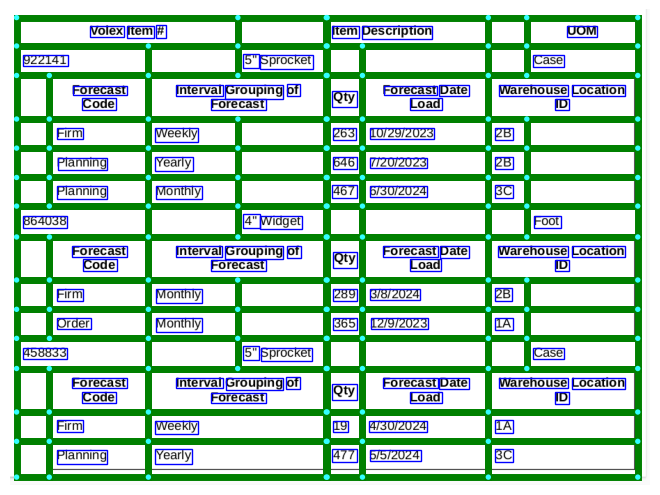

In [28]:
import matplotlib.patches as patches

plt.gca().set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
intersections=[i for in_ in line_m.intersections for i in in_] 
# for line in line_m.h_l+line_m.v_l:
    # a,b=line.point1,line.point2
    # plt.plot([a[1], b[1]], [a[0], b[0]], c='red', linewidth=2)
    # plt.scatter(a[1], a[0], **PLTOPTS)
    # plt.scatter(b[1], b[0], **PLTOPTS)
    # for a,b in [i for line in line_m.intersections for i in line]:
    #     plt.scatter(b, a, **PLTOPTS)
for a,b in intersections:
    plt.scatter(b, a, **PLTOPTS)

for x1,y1,x2,y2 in [b for box in box_l for b in box]:
    height,width=y2-y1,x2-x1
    rect = patches.Rectangle((x1, y1), width, height, linewidth=5, edgecolor='green', facecolor='none')
    plt.gca().add_patch(rect)

for x1,y1,x2,y2 in line_m.word_box:
    height,width=y2-y1,x2-x1
    rect = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='b', facecolor='none')
    plt.gca().add_patch(rect)



plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.imshow(im)
plt.show()
plt.close()

In [9]:
######
box_l = []
for i in range(len(line_m.intersections) - 2 + 1):
    boxes = []
    top_l, bot_l = line_m.intersections[i:i + 2]
    y1, x1 = top_l[0]
    y2, x2 = bot_l[-1]
    words = [word for word in line_m.word_box if y1 < word[1] and y2 > word[-1]]
    print(words)
    prev_t=0
    t_idx = 0
    b_idx = 1
    while t_idx < len(top_l) and b_idx<len(bot_l):
        print(f"{i}_prev_idx,{prev_t}")
        print(f"{i}_t_idx,{t_idx} | {len(top_l)}")
        print(f"{i}_b_idx,{b_idx} | {len(bot_l)}")
        # if top_l[t_idx][1]<bot_l[b_idx][1] and abs(top_l[t_idx][1] - bot_l[b_idx][1]) > 1:
        if top_l[t_idx][1]<bot_l[b_idx][1] and abs(top_l[t_idx][1] - bot_l[b_idx][1]) > .1:
            print("ABS_DIST_T_B:",abs(top_l[t_idx][1] - bot_l[b_idx][1]))
            t_idx+=1
        else:
            print("ABS_DIST_T_B:",abs(top_l[t_idx][1] - bot_l[b_idx][1]))
    # Now that b_idx is aligned with t_idx, check the line
        # Ensure b_idx didn't exceed the limit
            check_line = Line(top_l[t_idx], bot_l[b_idx])
            intersects = line_m.box_post_line_span(check_line, words)
            print('intersections:',intersects)
            print(check_line.point1,check_line.point2)
                # If there are no intersections, check for words in the box
            if not intersects and abs(check_line.m)>100:
                word_in_box = [word for word in intersects if ((top_l[prev_t][1] < word[0]) or (abs(word[0] - top_l[prev_t][1])/(word[2]-word[0])<.3)) and ((bot_l[b_idx][1] > word[-2]) or ((abs(word[-2] - bot_l[b_idx][1])/(word[2]-word[0]))<.3))]
                print("WIB: ", word_in_box)
                # if word_in_box:
                boxes.append([top_l[prev_t][1], top_l[prev_t][0], bot_l[b_idx][1], bot_l[b_idx][0]])
                prev_t=t_idx
            elif abs(check_line.m)>100:
                truth_bool=[]
                for word in intersects:
                    linex1,linex2=check_line.x(word[1]),check_line.x(word[-1])
                    word_space=word[2]-word[0]
                    truth_bool.append(abs(linex1-word[0])/word_space<0.2 or abs(linex2-word[2])/word_space<0.2)
                    print('LEFT_INTERSECT_SPACE:', abs(linex1-word[0])/word_space)
                    print('RIGHT_INTERSECT_SPACE:', abs(linex2-word[2])/word_space)
                if all(truth_bool):
                    boxes.append([top_l[prev_t][1], top_l[prev_t][0], bot_l[b_idx][1], bot_l[b_idx][0]])
                    prev_t=t_idx
            # else:
            #     word_in_box = [word for word in intersects if ((top_l[prev_t][1] < word[0]) or (abs(word[0] - top_l[prev_t][1])/(word[2]-word[0])<.1)) and ((bot_l[b_idx][1] > word[-2]) or ((abs(word[-2] - bot_l[b_idx][1])/(word[2]-word[0]))<.1))]
            #     if word_in_box and check_line.m>100:
            #         boxes.append([top_l[prev_t][1], top_l[prev_t][0], bot_l[b_idx][1], bot_l[b_idx][0]])
            #         prev_t=t_idx
            else:
                print("gradient",check_line.m)

            b_idx += 1
            
        # Increment t_idx only after checking all possible b_idx values for the current t_idx
    box_l.append(boxes)

[[34.119140625, 20.4833984375, 84.0341796875, 32.48828125], [86.5615234375, 20.4833984375, 97.9345703125, 33.12011718749999], [161.1181640625, 20.4833984375, 231.251953125, 31.856445312500004], [234.4111328125, 19.851562500000004, 255.26171875, 33.12011718749999], [258.4208984375, 21.115234374999996, 265.37109375, 29.9609375], [340.5595703125, 20.4833984375, 383.5244140625, 32.48828125], [462.50390625, 19.851562500000004, 482.72265625, 33.12011718749999], [484.6181640625, 20.4833984375, 509.8916015625, 32.48828125], [511.787109375, 19.851562500000004, 540.2197265625, 35.015625], [542.7470703125, 19.219726562499993, 587.607421875, 33.12011718749999]]
0_prev_idx,0
0_t_idx,0 | 7
0_b_idx,1 | 9
ABS_DIST_T_B: 104.01438652156128
0_prev_idx,0
0_t_idx,1 | 7
0_b_idx,1 | 9
ABS_DIST_T_B: 1.2191417937401638e-06
intersections: []
(15.091326713662031, 112.92764512442247) (36.98528534183972, 112.92764390528068)
WIB:  []
0_prev_idx,1
0_t_idx,1 | 7
0_b_idx,2 | 9
ABS_DIST_T_B: 8.888706209953696
0_prev_id

In [250]:
word_in_box

[]

In [105]:
line_m.intersections

[[(11.318872230127454, 8.948555367127932),
  (11.318872230127454, 326.7469188296736),
  (11.318872230127454, 453.6596165353398),
  (11.318872230127454, 453.6893907957423),
  (11.318872230127454, 454.86409071267934),
  (11.318872230127454, 686.3507028287653),
  (11.318872230127454, 686.547168266857),
  (11.318872230127454, 686.863430860658),
  (11.318872230127454, 686.9575866768504),
  (11.318872230127454, 741.4688820798483),
  (11.318872230127454, 900.9571131467819)],
 [(52.11204180121422, 8.948555984926198),
  (52.11204180121422, 198.22229037440607),
  (52.11204180121422, 198.46908361874054),
  (52.11204180121422, 198.52074059704142),
  (52.11204180121422, 326.7469187287433),
  (52.11204180121422, 453.6596149681417),
  (52.11204180121422, 453.6893885831299),
  (52.11204180121422, 454.86408850135973),
  (52.11204180121422, 505.5799834469756),
  (52.11204180121422, 505.6372119046451),
  (52.11204180121422, 505.72932948827986),
  (52.11204180121422, 686.350700616826),
  (52.1120418012142

In [91]:
line_m.intersections

[[(11.318872230127454, 8.948555367127932),
  (11.318872230127454, 326.7469188296736),
  (11.318872230127454, 453.6596165353398),
  (11.318872230127454, 453.6893907957423),
  (11.318872230127454, 454.86409071267934),
  (11.318872230127454, 686.3507028287653),
  (11.318872230127454, 686.547168266857),
  (11.318872230127454, 686.863430860658),
  (11.318872230127454, 686.9575866768504),
  (11.318872230127454, 741.4688820798483),
  (11.318872230127454, 900.9571131467819)],
 [(52.11204180121422, 8.948555984926198),
  (52.11204180121422, 198.22229037440607),
  (52.11204180121422, 198.46908361874054),
  (52.11204180121422, 198.52074059704142),
  (52.11204180121422, 326.7469187287433),
  (52.11204180121422, 453.6596149681417),
  (52.11204180121422, 453.6893885831299),
  (52.11204180121422, 454.86408850135973),
  (52.11204180121422, 505.5799834469756),
  (52.11204180121422, 505.6372119046451),
  (52.11204180121422, 505.72932948827986),
  (52.11204180121422, 686.350700616826),
  (52.1120418012142

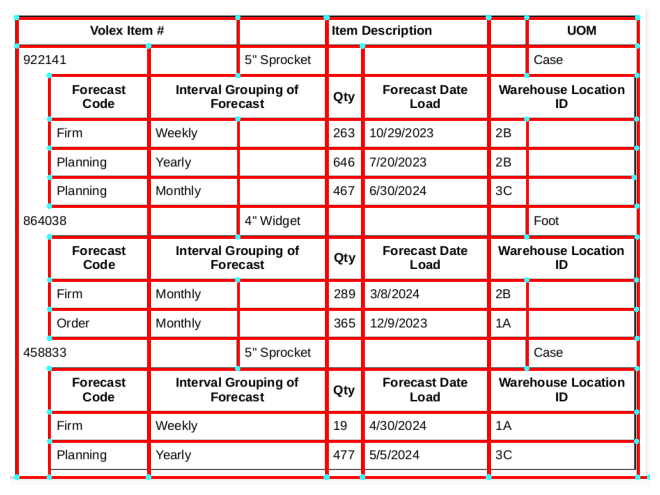

In [21]:
plt.gca().set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
for line in line_m.h_l+line_m.v_l:
    a,b=line.point1,line.point2
    plt.plot([a[1], b[1]], [a[0], b[0]], c='red', linewidth=2)
    plt.scatter(a[1], a[0], **PLTOPTS)
    plt.scatter(b[1], b[0], **PLTOPTS)
    # for a,b in [i for line in line_m.intersections for i in line]:
    #     plt.scatter(b, a, **PLTOPTS)
        
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.imshow(im)
plt.show()
plt.close()

In [ ]:
line_m.box_within_line_span(line_m.v_l)

In [ ]:
line_m.__dict__

{'v_l': [{'m': 79484167.64773428, 'b': -1086575693.5022736, 'is_vertical': True, 'is_horizontal': False, 'point1': (35.63860171660781, 13.670341670513153), 'point2': (830.4802781939507, 13.670341670513153)},
  {'m': -1582729.2740345, 'b': 43328469.75223466, 'is_vertical': True, 'is_horizontal': False, 'point1': (379.85063168406487, 27.375543490052223), 'point2': (395.67792442440987, 27.375543490052223)},
  {'m': 12479829.734563826, 'b': -873390688.9027535, 'is_vertical': True, 'is_horizontal': False, 'point1': (692.8630717992783, 69.98423859477043), 'point2': (817.6613691449165, 69.98423859477043)},
  {'m': -22533093.489706516, 'b': 1577240795.0719523, 'is_vertical': True, 'is_horizontal': False, 'point1': (137.63702942430973, 69.99662220478058), 'point2': (362.9679643213749, 69.99662220478058)},
  {'m': -22601555.556058884, 'b': 1583607676.8245826, 'is_vertical': True, 'is_horizontal': False, 'point1': (414.76068741083145, 70.06628513336182), 'point2': (640.7762429714203, 70.066285133

In [ ]:
line_m.box_within_line_span(line_m.v_l[1],line_m.word_box)

[[125.68359375, 51.26562499999999, 184.765625, 70.6015625],
 [189.0625, 51.26562499999999, 236.328125, 71.67578125],
 [238.4765625, 51.26562499999999, 256.73828125, 72.75],
 [508.10546875, 51.26562499999999, 555.37109375, 71.67578125],
 [560.7421875, 52.33984374999999, 684.27734375, 74.8984375],
 [929.19921875, 51.26562499999999, 982.91015625, 71.67578125],
 [24.70703125, 101.75390624999999, 100.9765625, 121.08984375],
 [378.125, 100.67968749999999, 400.68359375, 122.16406249999999],
 [403.90625, 101.75390624999999, 475.87890625, 125.38671874999999],
 [837.890625, 100.67968749999999, 889.453125, 121.08984375],
 [109.5703125, 154.39062500000003, 204.1015625, 172.65234374999997],
 [288.96484375, 153.31640625000003, 368.45703125, 172.65234374999997],
 [373.828125, 153.31640625000003, 473.73046875, 176.94921875000003],
 [479.1015625, 153.31640625000003, 503.80859375, 173.72656249999997],
 [645.60546875, 154.39062500000003, 740.13671875, 172.65234374999997],
 [744.43359375, 153.316406250000

In [ ]:
[space/max(line_m.v_spaces) for space in line_m.v_spaces]

[1.0,
 0.2198634603918973,
 0.28394312950076345,
 0.22061268302501555,
 0.21882579753488585,
 0.2827916516917847,
 0.21794721027894332,
 0.06373254738900067,
 0.12375284611136728,
 0.06184681041985141,
 0.2829514986058922,
 0.21843560569494816,
 0.21853541360213552,
 0.21813541066034758,
 0.21842301786615917,
 0.28275624842331565,
 0.21848756134122435,
 0.28303234763859214,
 0.21827276608625115,
 0.12444410456963909,
 0.061731576251893225,
 0.06363153623347319,
 0.9996086878278738]

In [ ]:
line_m.v_spaces

[1.0,
 0.21986341770954065,
 0.283943193607609,
 0.2206126751934826,
 0.019386407357067415,
 0.01833714630057779,
 0.28279163084760955,
 0.2188265148951184,
 0.2179472619557433,
 0.06373586706321872,
 0.0618480250042318,
 0.1237553504640081,
 0.28295152648974875,
 0.21843556453263682,
 0.21853538641883072,
 0.022459598173283992,
 0.21842360412254938,
 0.21813677334951256,
 0.28275714777801,
 0.018634935896256533,
 0.01911808269318817,
 0.21848793518316123,
 0.28303238321425983,
 0.21827274478458525,
 0.12444429444442616,
 0.06363154007893823,
 0.06173182162870278,
 0.9996086483720046]

In [ ]:
lines=sorted([Line(a,b) for a,b in nlines],key=lambda line: line.point2[0]-line.point1[0] if line.is_vertical else line.point2[1]-line.point1[1])
spaces=sorted([np.sqrt((np.array(line.point2)-np.array(line.point1))@(np.array(line.point2)-np.array(line.point1)).T) if line.is_vertical else line.point2[1]-line.point1[1] for line in lines])


In [ ]:
line_m=LineManager(nlines,im)

In [ ]:
spaces

[12.097955485857398,
 12.294422548595474,
 12.61317925951452,
 12.790206796196522,
 14.817748327724924,
 30.761755406856537,
 40.727647469410385,
 40.80431279352422,
 41.98098912191639,
 42.049818981868995,
 81.64774913766578,
 82.10228080092052,
 143.79098198731188,
 143.91601236926456,
 144.00571969568784,
 144.10524933489123,
 144.1131402305878,
 144.1476918335703,
 144.1789978463745,
 144.37107022716162,
 145.0551681716518,
 145.54949174521076,
 186.54938620512507,
 186.5721364539475,
 186.67762780626995,
 186.73097313262733,
 187.33188144268684,
 659.4930712256761,
 659.7512659576806,
 839.4256289042532,
 842.7429826930165,
 842.8368425145745,
 842.8814991936088,
 843.1987861990929,
 843.3477718904614,
 843.3845955058932,
 843.8251505568624,
 843.9273603968322,
 843.9328757226467,
 844.0414396561682,
 844.1557551398873,
 891.1576732732356,
 892.0085577806458,
 908.5315247438848]

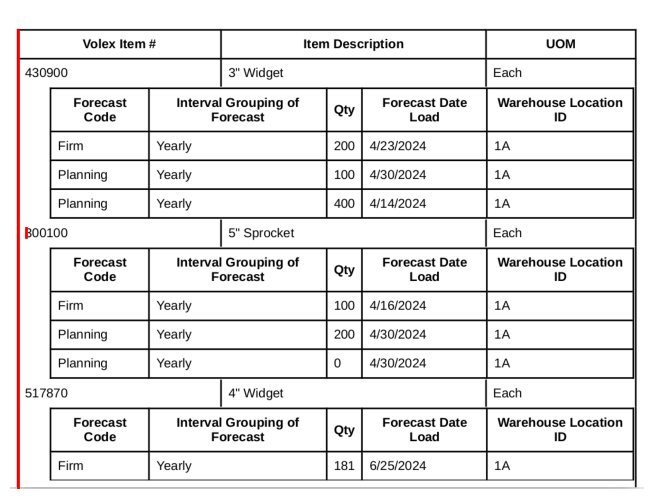

In [ ]:
imname='test.png'
plt.gca().set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
for line in line_m.v_l[:2]:
    a,b=line.point1,line.point2
    plt.plot([a[1], b[1]], [a[0], b[0]], c='red', linewidth=2)
# for line in line_m.intersections:
#     for a in line:
#         plt.scatter(a[1], a[0], **PLTOPTS)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.imshow(im)
plt.show()
plt.close()

In [ ]:
1234567890-=-[-=============---------------======================]
1231342345

SyntaxError: invalid syntax (3369081993.py, line 1)